# Belajar Pengembangan Machine Learning - Proyek Akhir_Image Classification Model Deployment


## Data Diri

Nama : Adi Bintang Pradana <br>
Alamat : Jl. Budi Mulia No. 1, Jakarta <br>
No. HP : 087784537428 <br>
Email : adibintangprada@gmail.com

## Import Library

In [11]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping

## Load Dataset

In [2]:
#!unzip '/content/drive/MyDrive/Dataset for Colabs/archive.zip'

## Manual Train Test Split and Image Augmentation

In [3]:
train = '/content/seg_train/seg_train'
os.listdir(train)

['mountain', 'sea', 'buildings', 'forest', 'glacier', 'street']

In [4]:
Normalized = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255)
data = Normalized.flow_from_directory(train ,target_size=(150,150),
                                               batch_size = 128,
                                               class_mode='sparse',shuffle = 'True')

Found 14034 images belonging to 6 classes.


In [5]:
test_path =  '/content/seg_test/seg_test'
test_data = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255)
test_data = test_data.flow_from_directory(test_path ,target_size = (150,150),
                                               batch_size = 128,
                                               class_mode='sparse',shuffle = 'True')

Found 3000 images belonging to 6 classes.


## Creating Model Architecture

In [9]:
res = tf.keras.applications.resnet_v2.ResNet50V2(
    input_shape=None, 
    include_top=False , weights= 'imagenet', input_tensor=None, pooling=None)

tf.keras.Sequential()

for layer in res.layers:
  layer.trainable = False
global_pool = tf.keras.layers.GlobalAveragePooling2D()(res.output)
flat = tf.keras.layers.Flatten()(global_pool)
drop = tf.keras.layers.Dropout(0.5)(flat)
dense1 = tf.keras.layers.Dense(1000, activation = 'relu')(drop)
drop = tf.keras.layers.Dropout(0.5)(dense1)
dense2 = tf.keras.layers.Dense(1000, activation = 'relu')(drop)
last_layer = tf.keras.layers.Dense(6 ,activation = 'softmax')(dense2)
model = tf.keras.Model (inputs = res.input ,outputs = last_layer)

model.compile(
    optimizer = tf.keras.optimizers.RMSprop(),
    loss = 'SparseCategoricalCrossentropy',
    metrics = 'accuracy' 
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, None, None, 6 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

## Defining Callback and Best Model Checkpoint

In [12]:
filepath= "final_project.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=False)

early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta = 0, 
                               patience = 5, 
                               verbose = 1, 
                               restore_best_weights=True)

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.9):
      print("\nAkurasi telah mencapai >90%!")
      self.model.stop_training = True
callbacks = myCallback()

callback_params = [checkpoint,
                   early_stopping,
                   callbacks]

## Run the Model

In [13]:
hist = model.fit(data , validation_data= test_data ,epochs = 30 ,callbacks=callback_params)

Epoch 1/30
110/110 [==============================] - 723s 7s/step - loss: 0.7700 - accuracy: 0.8022 - val_loss: 0.3262 - val_accuracy: 0.8840

Epoch 00001: val_accuracy improved from -inf to 0.88400, saving model to final_project.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/30
110/110 [==============================] - 697s 6s/step - loss: 0.3821 - accuracy: 0.8605 - val_loss: 0.2978 - val_accuracy: 0.8943

Epoch 00002: val_accuracy improved from 0.88400 to 0.89433, saving model to final_project.h5
Epoch 3/30
110/110 [==============================] - 696s 6s/step - loss: 0.3438 - accuracy: 0.8787 - val_loss: 0.3091 - val_accuracy: 0.8933

Epoch 00003: val_accuracy did not improve from 0.89433
Epoch 4/30
110/110 [==============================] - 695s 6s/step - loss: 0.3337 - accuracy: 0.8829 - val_loss: 0.2684 - val_accuracy: 0.9007

Epoch 00004: val_accuracy improved from 0.89433 to 0.90067, saving model to final_project.h5
Epoch 5/30
110/110 [==============================] - 693s 6s/step - loss: 0.3235 - accuracy: 0.8875 - val_loss: 0.2910 - val_accuracy: 0.9027

Epoch 00005: val_accuracy improved from 0.90067 to 0.90267, saving model to final_project.h5
Epoch 6/30
110/110 [==============================] - 692s 6s/step - loss: 0.3199 - accura

In [14]:
best_model = tf.keras.models.load_model("final_project.h5")

## Loss and Accuracy Visualization

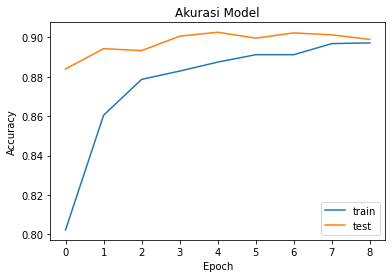

In [15]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

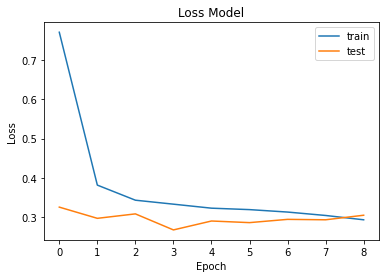

In [16]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## Saving in TFLite Format

In [17]:
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
tflite_model = converter.convert()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tmp/tmpoxiut05h/assets


In [18]:
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)